# 와인 품질 분류 데이터(sklearn)

1.   *데이터 탐색(분포 확인) 및 전처리*
2.   *활성화 함수 변경-relu 사용*
3.   *다양한 옵티마이저 사용해보기*
4.   *hidden 레이어 및 뉴런 수 변경*
5.   *결론 및 정리, 최적 모델*




<h1> 1.데이터 탐색(분포 확인) 및 전처리

In [1]:
import torch
from torch import nn, optim
import sklearn.datasets
from torch.utils.data import  TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


%matplotlib inline

In [2]:
data=sklearn.datasets.load_wine() # 와인 데이터 분류하기

In [3]:
data.feature_names #feature label들

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

In [4]:
data.target_names #타겟 종류 0, 1, 2 세가지로 분류됨.

array(['class_0', 'class_1', 'class_2'], dtype='<U7')

In [5]:
input = data.data
output = data.target

In [7]:
input.shape 

(178, 13)

In [8]:
output.shape

(178,)

데이터 개수는 178개, feature 개수는 13개이다.

In [140]:
df = pd.DataFrame(data=input, columns = data.feature_names)
df.head()#판다스 폼으로 전환해서 전처리가 필요한 부분이 있는지 확인.

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,1.514341,-0.560668,0.231400,-1.166303,1.908522,0.806722,1.031908,-0.657708,1.221438,0.251009,0.361158,1.842721,1.010159
1,0.245597,-0.498009,-0.825667,-2.483841,0.018094,0.567048,0.731565,-0.818411,-0.543189,-0.292496,0.404908,1.110317,0.962526
2,0.196325,0.021172,1.106214,-0.267982,0.088110,0.806722,1.212114,-0.497005,2.129959,0.268263,0.317409,0.786369,1.391224
3,1.686791,-0.345835,0.486554,-0.806975,0.928300,2.484437,1.462399,-0.979113,1.029251,1.182732,-0.426341,1.180741,2.328007
4,0.294868,0.227053,1.835226,0.450674,1.278379,0.806722,0.661485,0.226158,0.400275,-0.318377,0.361158,0.448336,-0.037767


In [10]:
df[df.isna()].count() #결측치 없음

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
dtype: int64

In [11]:
df.info() #dtype == object 없으므로 onehotencoding 필요 X

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dtypes: fl

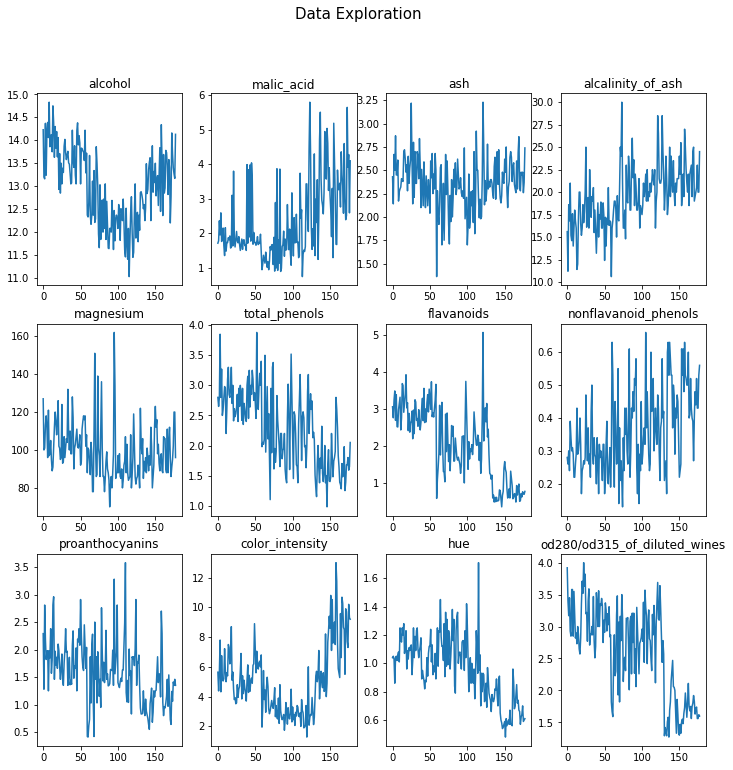

In [12]:
f, axes = plt.subplots(3, 4)
f.set_size_inches((12, 12))

f.suptitle('Data Exploration ', fontsize = 15)
count = 0
for i in range(3):
  for j in range(4):
    axes[i,j].plot(df[data.feature_names[count]])
    axes[i,j].set_title(data.feature_names[count])
    count+=1

#데이터 표준화 외에는 전처리가 필요해 보이는 게 없었다.

In [13]:
def standardization(x_data, col_names):
  for i in range(len(col_names)):
    x_data[col_names[i]] = x_data[col_names[i]].apply(lambda x: (x-x_data[col_names[i]].mean())/x_data[col_names[i]].std())

  return x_data

  #모듈 사용하지 않고 표준화 함수 정의해보았음. 


In [14]:
df2 = standardization(df, data.feature_names)

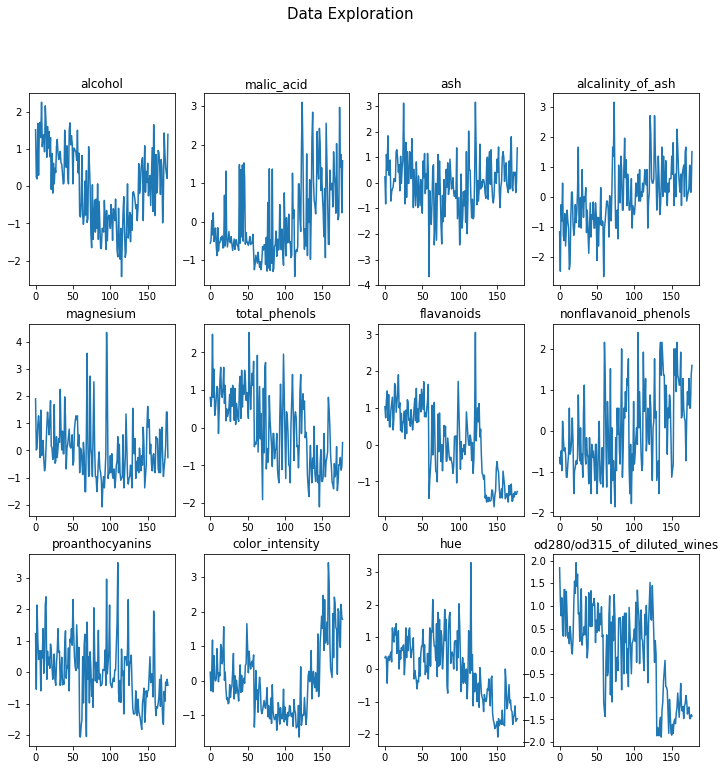

In [15]:
f, axes = plt.subplots(3, 4)
f.set_size_inches((12, 12))

f.suptitle('Data Exploration ', fontsize = 15)
count = 0
for i in range(3):
  for j in range(4):
    axes[i,j].plot(df2[data.feature_names[count]])
    axes[i,j].set_title(data.feature_names[count])
    count+=1

#표준화 정상적으로 종료됨

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

#gpu 세팅

In [17]:
input = df2.to_numpy() #판다스 폼 다시 numpy로 변환함.
input.shape

(178, 13)

In [18]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

# 데이터를 tensor로 바꿔주고 gpu 연산이 가능해지도록 gpu에 옮김
# label 값을 왜 long 에 옮겨놓는가? loss function이 다르기 때문 

In [19]:
print(x_train[0])
print(y_train[0])

#input 13개 (속성이 13개)
#y의 class는 3개

tensor([ 0.9231, -0.5428,  0.1585, -1.0465, -0.7521,  0.4872,  0.7316, -0.5774,
         0.3828,  0.2338,  0.8424,  0.4061,  1.8199], device='cuda:0')
tensor(0, device='cuda:0')


파이토치에서는 데이터셋을 좀 더 쉽게 다룰 수 있도록 유용한 도구로서 torch.utils.data.Dataset과 torch.utils.data.DataLoader를 제공합니다. 이를 사용하면 미니 배치 학습, 데이터 셔플(shuffle), 병렬 처리까지 간단히 수행할 수 있습니다. 기본적인 사용 방법은 Dataset을 정의하고, 이를 DataLoader에 전달하는 것
- init : class 에서 객체가 생성되면 바로 실행되는 함수
- len : observation 수를 정의하는 함수
- getitem : iteration 마다 해당하는 데이터를 돌려주는 함수

In [20]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self):
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

In [21]:
batch_size = 8

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size) 

In [22]:
model = nn.Sequential(
          nn.Linear(17,398, bias=True),
          nn.Sigmoid(),
          nn.Linear(398,15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15,5, bias=True), 
          nn.Softmax()
          ).to(device)

class로 구현 가능
- init : 초기 생성 함수
- foward : 순전파(입력값 => 예측값 의 과정)

<h1>  2.   활성화 함수 변경-relu 사용


아래는 Sigmoid 사용된 기본 세팅된 모듈

In [23]:
class Model(torch.nn.Module):#기본 세팅된 모듈

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,398, bias=True), # input_layer = 30, hidden_layer1 = 398 
          nn.Sigmoid(),
        nn.BatchNorm1d(398)
    )
    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.Sigmoid()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 5, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [24]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [25]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Softmax(dim=None)
  )
)

In [27]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [28]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.5350393056869507
10 1.3265035152435303
20 1.1811038255691528
30 1.0715065002441406
40 1.0037901401519775
50 0.9633995890617371
60 0.940343976020813
70 0.9297760128974915
80 0.9237669706344604
90 0.9200016260147095


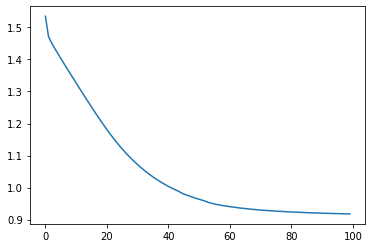

In [29]:
plt.plot(losses)
plt.show()

In [30]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [31]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [9.8844367e-01 8.9617642e-03 1.2915127e-03 7.7789603e-04 5.2505406e-04]
argmax를 한 후의 output은 0
accuracy는 0.9629629629629629


<h3> RELU 함수로 대체, 메소드 오버라이딩으로 함수 구현하였음.

In [32]:
class Model2(torch.nn.Module):

  def __init__(self):
    super(Model2, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,398, bias=True), # input_layer = 30, hidden_layer1 = 398 
        ReLU(),
        nn.BatchNorm1d(398)
    )

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        ReLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        ReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 5, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )


  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output


class ReLU(nn.ReLU):
  def forward(self, x):#오버라이딩함
    return torch.max(torch.zeros_like(x),x)

In [33]:
model = Model2().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model2(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Softmax(dim=None)
  )
)

In [35]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [36]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.5660532712936401
10 0.9132800102233887
20 0.9048642516136169
30 0.9048526287078857
40 0.9048631191253662
50 0.9048442244529724
60 0.9048370718955994
70 0.9048357605934143
80 0.9048354029655457
90 0.9048351645469666


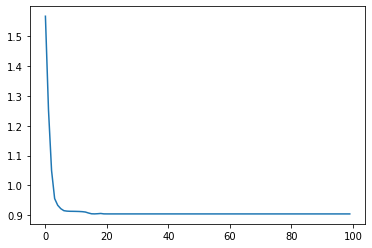

In [37]:
plt.plot(losses)
plt.show()

In [38]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [39]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [1.0000000e+00 3.3328429e-10 2.2936457e-12 1.4878891e-14 1.6798721e-17]
argmax를 한 후의 output은 0
accuracy는 0.9444444444444444


learning rate를 0.0001, epoch 2000으로 세팅 후 다시 시도

In [52]:
model = Model2().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model2(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Softmax(dim=None)
  )
)

In [53]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.0001)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [54]:
losses = []
for epoch in range(2000):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 100 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.5858460664749146
100 1.1933836936950684
200 1.1111546754837036
300 1.0898363590240479
400 1.0705381631851196
500 1.0318294763565063
600 0.9638868570327759
700 0.9241518974304199
800 0.9135907888412476
900 0.909895658493042
1000 0.9081833958625793
1100 0.9072349667549133
1200 0.9066475629806519
1300 0.9062537550926208
1400 0.9059761762619019
1500 0.9057726860046387
1600 0.9056179523468018
1700 0.9054977297782898
1800 0.9054023623466492
1900 0.9053247570991516


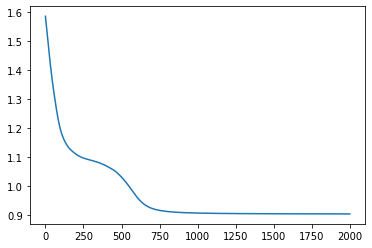

In [55]:
plt.plot(losses)
plt.show()

In [56]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [57]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [9.9973172e-01 1.8393323e-05 3.2853375e-05 2.1209902e-04 4.8481147e-06]
argmax를 한 후의 output은 0
accuracy는 0.9814814814814815


accuracy 0.98148로 완벽에 근사한 모듈이 구축되었음.

<h1> 3.   다양한 옵티마이저 사용해보기

https://velog.io/@chang0517/Optimizer-%EC%A2%85%EB%A5%98-%EB%B0%8F-%EC%A0%95%EB%A6%AC


SGD lr=0.01 epoch = 200으로 진행

In [84]:
model = Model2().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model2(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Softmax(dim=None)
  )
)

In [85]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.SGD(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [86]:
losses = []
for epoch in range(200):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.6213692426681519
10 1.5850130319595337
20 1.5476740598678589
30 1.5061136484146118
40 1.458583950996399
50 1.405681848526001
60 1.3516151905059814
70 1.301979899406433
80 1.26008141040802
90 1.2263741493225098
100 1.199076533317566
110 1.1756523847579956
120 1.1556519269943237
130 1.137742519378662
140 1.1205073595046997
150 1.1024692058563232
160 1.082491159439087
170 1.06022047996521
180 1.036395788192749
190 1.0136176347732544


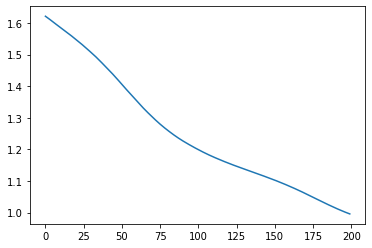

In [87]:
plt.plot(losses)
plt.show()

In [88]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [89]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.8699784  0.05130396 0.00341974 0.04955046 0.02574742]
argmax를 한 후의 output은 0
accuracy는 1.0


<h1> **최대 accuracy가 나왔음**

Adagrad 알고리즘 사용 #adam과 유사하나 하위버전

In [90]:
model = Model2().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model2(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Softmax(dim=None)
  )
)

In [92]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adagrad(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [93]:
losses = []
for epoch in range(200):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.6246163845062256
10 0.9238169193267822
20 0.915440022945404
30 0.9143307209014893
40 0.9138740301132202
50 0.9136268496513367
60 0.9134740233421326
70 0.9133703112602234
80 0.9132950305938721
90 0.9132382273674011
100 0.9131930470466614
110 0.9131556749343872
120 0.9131228923797607
130 0.9130910038948059
140 0.9130510687828064
150 0.9129204750061035
160 0.9057731628417969
170 0.90533047914505
180 0.9051815867424011
190 0.905110776424408


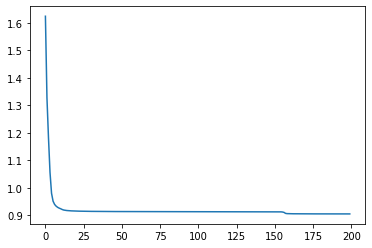

In [94]:
plt.plot(losses)
plt.show()

In [95]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [96]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [9.9966383e-01 3.0312318e-04 7.8669495e-07 6.2489348e-06 2.5952791e-05]
argmax를 한 후의 output은 0
accuracy는 1.0


adam과 유사한 알고리즘인데도, 최적값을 잘 찾아내었다.



RMSprop, 같은 환경에서 진행

In [97]:
model = Model2().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model2(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Softmax(dim=None)
  )
)

In [98]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.RMSprop(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [99]:
losses = []
for epoch in range(200):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.6688768863677979
10 0.9209720492362976
20 0.9209641218185425
30 0.92096346616745
40 0.9209631085395813
50 0.920962929725647
60 0.9209628105163574
70 0.9209626913070679
80 0.9209626317024231
90 0.9209625124931335
100 0.9209625124931335
110 0.9209624528884888
120 0.9209622740745544
130 0.9209622740745544
140 0.9209622144699097
150 0.9209622144699097
160 0.9209622144699097
170 0.9209621548652649
180 0.9209621548652649
190 0.9209620952606201


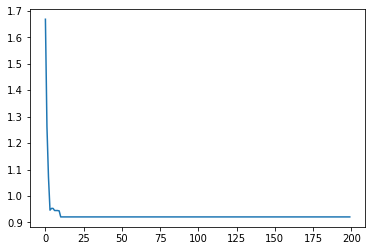

In [100]:
plt.plot(losses)
plt.show()

In [101]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [102]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [1.0000000e+00 2.1999530e-13 1.0172967e-19 2.0015659e-11 3.9256265e-17]
argmax를 한 후의 output은 0
accuracy는 0.9259259259259259


아담이 더 잘 나와야 할 것 같아서, 같은 환경(lr, epoch)에서 다시 돌려보았다.

In [145]:
model = Model2().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model2(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Softmax(dim=None)
  )
)

In [146]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [147]:
losses = []
for epoch in range(200):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.597493290901184
10 0.9060017466545105
20 0.9048998951911926
30 0.9048507213592529
40 0.9048399925231934
50 0.9048371911048889
60 0.9048361778259277
70 0.9048354625701904
80 0.9048351645469666
90 0.9048348665237427
100 0.9048347473144531
110 0.9048345685005188
120 0.9048343896865845
130 0.9048343300819397
140 0.9048342108726501
150 0.9048340916633606
160 0.9048340320587158
170 0.904833972454071
180 0.9048339128494263
190 0.9048338532447815


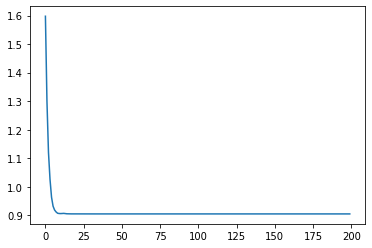

In [148]:
plt.plot(losses)
plt.show()

In [149]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [150]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [9.9999917e-01 7.7766964e-07 2.7266190e-15 7.4241305e-18 1.8799171e-13]
argmax를 한 후의 output은 0
accuracy는 0.9629629629629629


현재로서 가장 효과적인 세팅은 SGD lr 0.01, epoch = 200이 가장 적절하나, 같은 모듈로 다시 돌렸을 때, 무조건 적인 100의 정확도가 나오는 것이 아니므로, 조금 더 강건한 모듈을 구축해 보자.

<h1> 4.   hidden 레이어 및 뉴런 수 변경


Model1 = 처음 기본 제공된 모델 <br>
Model2 = 활성화함수만 ReLU로 변경





Model 3 레이어 수 변경 없이, 뉴런 수만 200, 20, 10, 3으로 변경

In [183]:
class Model3(torch.nn.Module):

  def __init__(self):
    super(Model3, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,200, bias=True),
        ReLU(),
        nn.BatchNorm1d(200)
    )

    self.layer2 = nn.Sequential(
          nn.Linear(200,20, bias=True),
        ReLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(20,10, bias=True), 
        ReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 3, bias=True), 
        nn.Softmax()
    )


  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output


class ReLU(nn.ReLU):
  def forward(self, x):#오버라이딩함
    return torch.max(torch.zeros_like(x),x)

In [184]:
model = Model3().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model3(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=200, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=200, out_features=20, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)

In [185]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.SGD(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [186]:
losses = []
for epoch in range(200):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.164177417755127
10 1.1184945106506348
20 1.07737398147583
30 1.0388550758361816
40 1.0026617050170898
50 0.9693491458892822
60 0.9335460066795349
70 0.8993631601333618
80 0.8690289258956909
90 0.8423363566398621
100 0.8197369575500488
110 0.7994117736816406
120 0.7818390727043152
130 0.7650960087776184
140 0.7477133274078369
150 0.7295798063278198
160 0.7113813757896423
170 0.6947833299636841
180 0.6797758936882019
190 0.6668996214866638


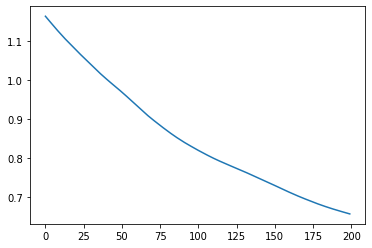

In [187]:
plt.plot(losses)
plt.show()

In [188]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [189]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.92479855 0.05399166 0.02120982]
argmax를 한 후의 output은 0
accuracy는 0.9814814814814815


조금 더 복잡하게 만들어도 될 것 같다.

Model 4 층 하나 더 쌓고, 500 200 10 3으로 변경

In [197]:
class Model4(torch.nn.Module):

  def __init__(self):
    super(Model4, self).__init__()
    self.layer0 = nn.Sequential(
          nn.Linear(13,500, bias=True),
        ReLU(),
        nn.BatchNorm1d(500)
    ) 

    self.layer1 = nn.Sequential(
          nn.Linear(500,200, bias=True),
        ReLU(),
    )

    self.layer2 = nn.Sequential(
          nn.Linear(200,20, bias=True),
        ReLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(20,10, bias=True), 
        ReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 3, bias=True), 
        nn.Softmax()
    )


  def forward(self,x):
    output = self.layer0(x)
    output = self.layer1(output)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output


class ReLU(nn.ReLU):
  def forward(self, x):#오버라이딩함
    return torch.max(torch.zeros_like(x),x)

In [198]:
model = Model4().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model4(
  (layer0): Sequential(
    (0): Linear(in_features=13, out_features=500, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer1): Sequential(
    (0): Linear(in_features=500, out_features=200, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=200, out_features=20, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)

In [199]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.SGD(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [200]:
losses = []
for epoch in range(200):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.1288083791732788
10 1.038176417350769
20 0.9480867981910706
30 0.8615334630012512
40 0.7795130014419556
50 0.7207083106040955
60 0.6806127429008484
70 0.651960015296936
80 0.6323949694633484
90 0.6184821128845215
100 0.6081858277320862
110 0.6002812385559082
120 0.5939591526985168
130 0.5888319611549377
140 0.5846675634384155
150 0.5812322497367859
160 0.578227162361145
170 0.5756140947341919
180 0.573417067527771
190 0.5714666843414307


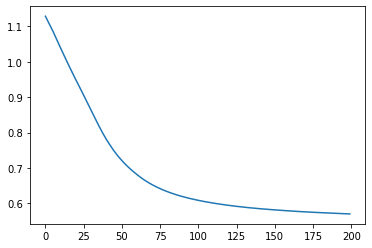

In [201]:
plt.plot(losses)
plt.show()

In [202]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [203]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.9521318  0.0390834  0.00878475]
argmax를 한 후의 output은 0
accuracy는 0.9814814814814815


Model2에 비해 높은 성능이 나오지 않음. 오히려 overfit인 것 같아 이번에는 레이어 수를 더 줄여서 진행해봄

Model 5 100, 10 , 3으로 진행

In [241]:
class Model5(torch.nn.Module):

  def __init__(self):
    super(Model5, self).__init__()
    self.layer0 = nn.Sequential(
          nn.Linear(13,100, bias=True),
        ReLU(),
        nn.BatchNorm1d(100)
    ) 

    self.layer1 = nn.Sequential(
          nn.Linear(100,10, bias=True),
        ReLU(),
    )

    self.layer2 = nn.Sequential(
        nn.Linear(10, 3, bias=True), 
        nn.Softmax()
    )


  def forward(self,x):
    output = self.layer0(x)
    output = self.layer1(output)
    output = self.layer2(output)
    return output


class ReLU(nn.ReLU):
  def forward(self, x):#오버라이딩함
    return torch.max(torch.zeros_like(x),x)

In [242]:
model = Model5().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model5(
  (layer0): Sequential(
    (0): Linear(in_features=13, out_features=100, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer1): Sequential(
    (0): Linear(in_features=100, out_features=10, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
)

In [243]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.SGD(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [244]:
losses = []
for epoch in range(200):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.0994383096694946
10 1.057063341140747
20 1.0192151069641113
30 0.9847779870033264
40 0.9514560699462891
50 0.9210085868835449
60 0.8946642279624939
70 0.8714278340339661
80 0.850273072719574
90 0.8306680917739868
100 0.8121814131736755
110 0.7956693172454834
120 0.7802799344062805
130 0.7651785016059875
140 0.7504825592041016
150 0.7361888289451599
160 0.7217853665351868
170 0.7083932757377625
180 0.6961618661880493
190 0.6845948696136475


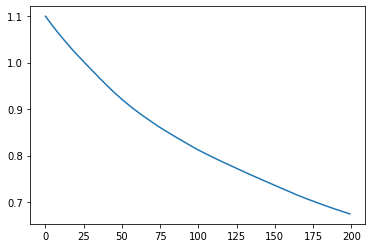

In [245]:
plt.plot(losses)
plt.show()

In [246]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [247]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.8876203  0.00471821 0.10766158]
argmax를 한 후의 output은 0
accuracy는 0.9074074074074074


너무 줄였는지, 이번에는 underfitting

Model6 이번엔 model 4에 dropout 기법을 사용해 보았다.

In [262]:
class Model6(torch.nn.Module):

  def __init__(self):
    super(Model6, self).__init__()
    self.layer0 = nn.Sequential(
          nn.Linear(13,500, bias=True),
        ReLU(),
        nn.BatchNorm1d(500)
    ) 

    self.layer1 = nn.Sequential(
          nn.Linear(500,200, bias=True),
        ReLU(),
    )

    self.layer2 = nn.Sequential(
          nn.Linear(200,20, bias=True),
        ReLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(20,10, bias=True), 
        ReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 3, bias=True), 
        nn.Softmax()
    )
    self.dropout = nn.Dropout(0.25)


  def forward(self,x):
    output = self.layer0(x)
    output = self.layer1(output)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.dropout(output)
    output = self.layer4(output)
    return output


class ReLU(nn.ReLU):
  def forward(self, x):#오버라이딩함
    return torch.max(torch.zeros_like(x),x)

In [263]:
model = Model6().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model6(
  (layer0): Sequential(
    (0): Linear(in_features=13, out_features=500, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer1): Sequential(
    (0): Linear(in_features=500, out_features=200, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=200, out_features=20, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=3, bias=True)
    (1): Softmax(dim=None)
  )
  (dropout): Dropout(p=0.25, inplace=False)
)

In [264]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.SGD(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [265]:
losses = []
for epoch in range(200):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.0756372213363647
10 0.9963862299919128
20 0.9256477952003479
30 0.8667834401130676
40 0.8398891091346741
50 0.8062317371368408
60 0.799924373626709
70 0.7874003052711487
80 0.7818594574928284
90 0.7482813596725464
100 0.754158079624176
110 0.7524511814117432
120 0.7400103807449341
130 0.7332913875579834
140 0.742763340473175
150 0.7445032000541687
160 0.7209365963935852
170 0.7262097597122192
180 0.7182638645172119
190 0.727509081363678


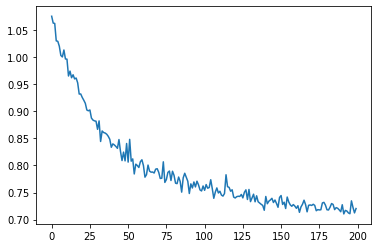

In [266]:
plt.plot(losses)
plt.show()

In [267]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [268]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.9728457  0.02341492 0.00373937]
argmax를 한 후의 output은 0
accuracy는 0.9259259259259259


오히려 accuracy가 떨어짐.

overfitting이라는 가설 자체가 틀린 것으로 보여졌다.

<h1> 5. 결론 및 정리, 최적 모델

sigmoid 보다는 ReLU에서 성능이 훨씬 우수했고, lr의 경우 줄일 경우 시간이 보다 많이 경과하고 epoch를 증가시키지 않으면 underfit이 발생함을 확인할 수 있었음(이론에서의 내용과 같았음). optimizer설정에서 adam이나, adagrad등 타 알고리즘에 비해 SGD가 성능이 우수하고 다양한 시도에도 10번 중 5번 이상 정확도 1을 보여주었음. 이 차이는 추가적인 공부가 필요할 듯. Layer 수나, 뉴런 개수 조절에서는 일정 수준 이상에서는 유의미한 차이가 없었으나, 확 줄이는 순간부터는 underfit으로 정확도에서 큰 차이를 보여주었음.

아래는 최종 모델

ReLU 사용, 4개 레이어, 398, 15, 10, 5(기본 세팅), lr = 0.01, epoch = 200, SGD

In [278]:
class Model2(torch.nn.Module):

  def __init__(self):
    super(Model2, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(13,398, bias=True), # input_layer = 30, hidden_layer1 = 398 
        ReLU(),
        nn.BatchNorm1d(398)
    )

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        ReLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        ReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 5, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )


  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output


class ReLU(nn.ReLU):
  def forward(self, x):#오버라이딩함
    return torch.max(torch.zeros_like(x),x)

In [279]:
model = Model2().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model2(
  (layer1): Sequential(
    (0): Linear(in_features=13, out_features=398, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): ReLU()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): ReLU()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Softmax(dim=None)
  )
)

In [280]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.SGD(model.parameters(), lr= 0.01, momentum=0.9)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [281]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.6311122179031372
10 1.2693461179733276
20 0.9641795754432678
30 0.9204986691474915
40 0.911285400390625
50 0.9080454707145691
60 0.9071488380432129
70 0.90667325258255
80 0.9063650965690613
90 0.9061540365219116


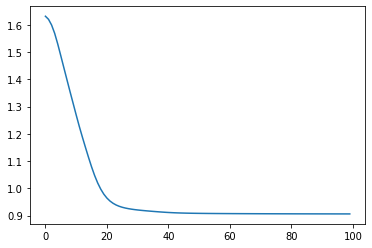

In [282]:
plt.plot(losses)
plt.show()

In [283]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [284]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [9.9924552e-01 2.8783138e-04 9.4419534e-05 1.2822344e-04 2.4405391e-04]
argmax를 한 후의 output은 0
accuracy는 1.0
